## Notebook setup

In [214]:
import sys

sys.path.append('../src')

import pandas as pd
import os
from db.connection import ConexionBD
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from scipy import stats

%matplotlib inline

In [215]:
conn = ConexionBD.obtener_conexion()

## Data Exploration

**Data setup**

In [216]:
query = """
    SELECT fecha_valor, importe, saldo, categoria
    FROM bancapp.movimientos_mview
    WHERE fecha_valor > '2022-12-31'
    """

results =  conn.execute(query).fetchall()
df = pd.DataFrame(results)
                 
# Convierte múltiples columnas a numérico; si encuentra basura, pone NaN
cols_numericas = ['importe', 'saldo']
df[cols_numericas] = df[cols_numericas].apply(pd.to_numeric, errors='coerce')

# Convierte a fecha
df['fecha_valor'] = pd.to_datetime(df['fecha_valor'])
df['mes_valor'] = df["fecha_valor"].dt.month
df['anio_valor'] = df["fecha_valor"].dt.year

**Expenses dataframe**

In [217]:
df_gastos = df[df.importe<0][["fecha_valor","mes_valor","anio_valor", "importe", "categoria"]]
df_gastos["importe"] = df_gastos["importe"].apply(abs)

df_gastos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1909 entries, 0 to 2204
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha_valor  1909 non-null   datetime64[ns]
 1   mes_valor    1909 non-null   int32         
 2   anio_valor   1909 non-null   int32         
 3   importe      1909 non-null   float64       
 4   categoria    1909 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 74.6+ KB


Tenemos un total de **1909** gastos registrados

In [218]:
df_gastos.describe()

,fecha_valor,mes_valor,anio_valor,importe
count,1909,1909.000000,1909.000000,1909.000000
mean,2024-07-23 01:26:44.819277312,6.701414,2024.047145,74.557910
min,2023-01-01 00:00:00,1.000000,2023.000000,0.490000
25%,2023-10-28 00:00:00,4.000000,2023.000000,10.250000
50%,2024-08-10 00:00:00,7.000000,2024.000000,27.350000
75%,2025-04-17 00:00:00,10.000000,2025.000000,71.170000
max,2025-12-31 00:00:00,12.000000,2025.000000,9000.000000
std,NaN,3.450747,0.806732,247.899444


### Estudio de atípicos

#### Por estadística

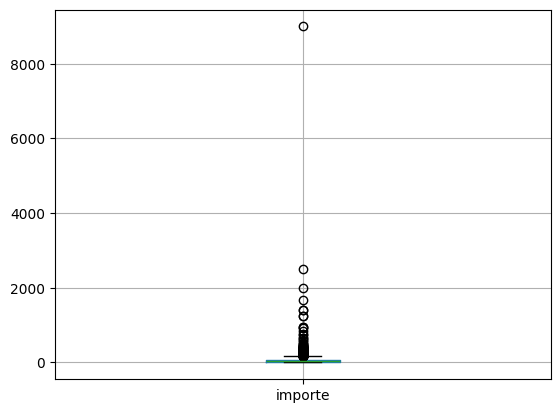

In [219]:
df_gastos.boxplot(column="importe");

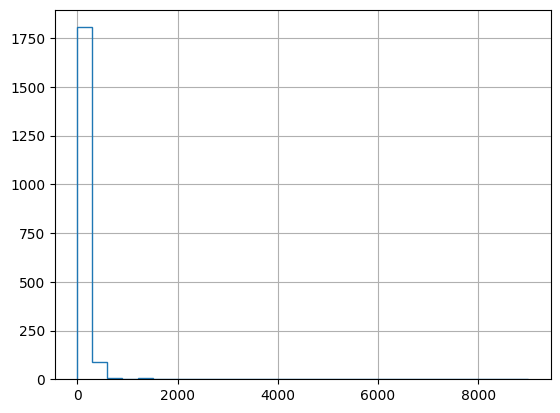

In [220]:
df_gastos.importe.hist(bins=30, histtype='step');

In [221]:
IQR = df_gastos.importe.quantile(0.75) - df_gastos.importe.quantile(0.25)

higher_fence = df_gastos.importe.quantile(0.75) + (IQR * 1.5)

print("Valor límite de gastos para atípicos: ", higher_fence)

Valor límite de gastos para atípicos:  162.55


In [222]:
df_gastos_outliers = df_gastos[df_gastos.importe >= higher_fence]

In [223]:
df_gastos_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 234 entries, 9 to 2185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   fecha_valor  234 non-null    datetime64[ns]
 1   mes_valor    234 non-null    int32         
 2   anio_valor   234 non-null    int32         
 3   importe      234 non-null    float64       
 4   categoria    234 non-null    object        
dtypes: datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 9.1+ KB


Estadísticamente, los gastos por encima de **162.55** euros son gastos atípicos. 

#### Por agrupación

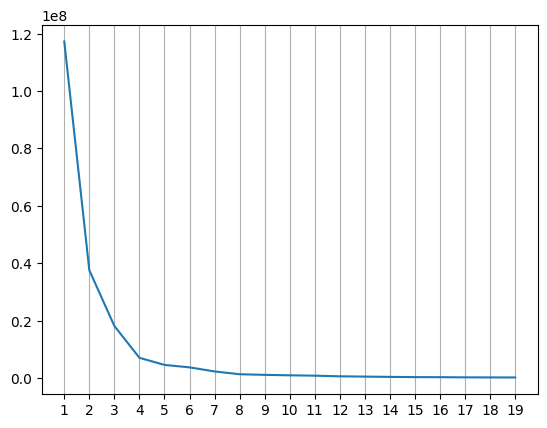

In [224]:
from sklearn.cluster import KMeans

inertia= []
max_clusters = 20
for i in range(1,max_clusters):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(df_gastos.importe.values.reshape(-1,1))
    inertia.append(kmeans.inertia_)
plt.plot(range(1,max_clusters), inertia);
plt.xticks(ticks=np.arange(1, max_clusters));
plt.grid(axis="x");

Se observa un codo en 4 grupos

**Clustering por densidad**

In [225]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=7.45, min_samples=3)
labels = db.fit_predict(df_gastos.importe.values.reshape(-1,1))

print("Numero de grupos:",len(set(labels)))

Numero de grupos: 5


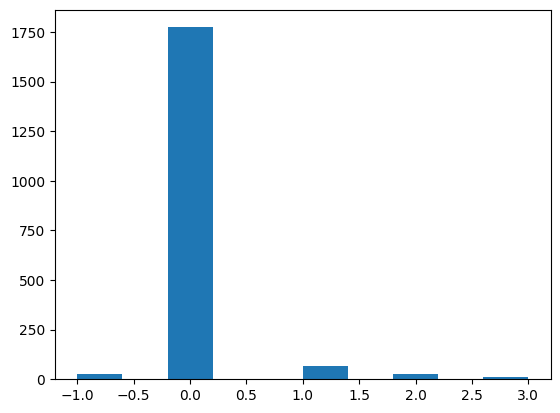

In [226]:
plt.hist(labels);

**Atípicos**

In [227]:
df_gastos["cluster"]= labels

In [228]:
df_gastos[df_gastos.cluster==-1].importe.describe()

count      27.000000
mean     1195.130370
std      1648.444304
min       291.000000
25%       499.500000
50%       738.780000
75%      1250.000000
max      9000.000000
Name: importe, dtype: float64

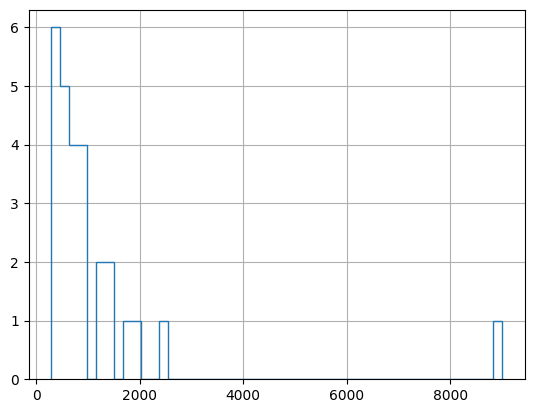

In [229]:
df_gastos[df_gastos.cluster==-1].importe.hist(bins=50, histtype='step');

In [230]:
df_gastos[df_gastos.cluster==-1].sort_values(by="importe")

,fecha_valor,mes_valor,anio_valor,importe,categoria,cluster
276,2025-05-03,5,2025,291.00,Movimientos excluidos,-1
405,2025-07-03,7,2025,429.00,Otros gastos,-1
1522,2024-03-07,3,2024,438.00,Movimientos excluidos,-1
473,2025-08-07,8,2025,450.00,Otros gastos,-1
97,2025-02-15,2,2025,452.00,Ocio y viajes,-1
640,2025-11-03,11,2025,462.00,Otros gastos,-1
255,2025-04-27,4,2025,499.00,Educación y salud,-1
1330,2024-06-17,6,2024,500.00,Otros gastos,-1
904,2023-01-20,1,2023,512.90,Ocio y viajes,-1
1596,2024-01-31,1,2024,585.83,Compras,-1


### Test de similitud entre los grupos de gastos por año, eliminando atípicos

**Test de ANOVA sobre el importe a través de los años**

In [231]:
df_gastos25 = df_gastos[(df_gastos.anio_valor == 2025) & (df_gastos.cluster!=-1)].importe
df_gastos24 = df_gastos[(df_gastos.anio_valor == 2024) & (df_gastos.cluster!=-1)].importe
df_gastos23 = df_gastos[(df_gastos.anio_valor == 2023) & (df_gastos.cluster!=-1)].importe

**Test de distribución normal sobre los datos**

In [232]:
def test_normal_dist(series):
    stat, p = stats.shapiro(series)

    return stat, p

In [233]:
_, p25 = test_normal_dist(df_gastos25)
_, p24 = test_normal_dist(df_gastos24)
_, p23 = test_normal_dist(df_gastos23)

print(f"{p25}, {p24}, {p23}")

1.3850614704584133e-34, 9.664559021126482e-33, 3.310882697641564e-31


Los gastos no siguen una distribución normal. Usamos Kruskal–Wallis para comprobar la similitud en la distribución de los datos por año

**Test de Kruskal–Wallis**

In [234]:
f_stat, p_value = stats.kruskal(df_gastos25, df_gastos24, df_gastos23)

print("F-statistic:", f_stat)
print("p-value:", p_value)

F-statistic: 0.23856653118582252
p-value: 0.887556350974094


El valor de p-value es mucho mayor que >0.05, de manera que asumimos que no hay diferencias en la distribución de los datos por año

### Análsis de grupos

#### Grupo mayoritario : Alimentación

In [235]:
df_gastos[df_gastos.cluster==0].importe.describe()

count    1774.000000
mean       42.751917
std        49.617437
min         0.490000
25%         9.885000
50%        24.165000
75%        56.690000
max       240.000000
Name: importe, dtype: float64

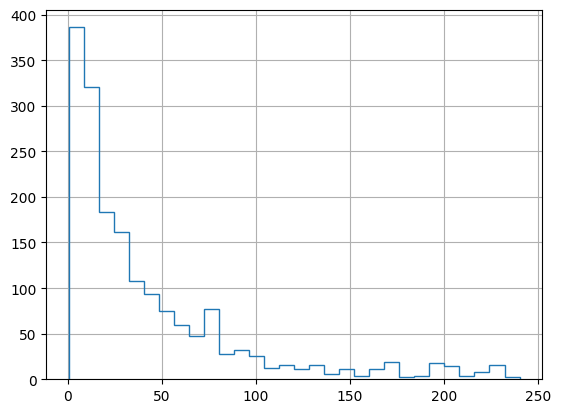

In [236]:
df_gastos[df_gastos.cluster==0].importe.hist(bins=30, histtype='step');

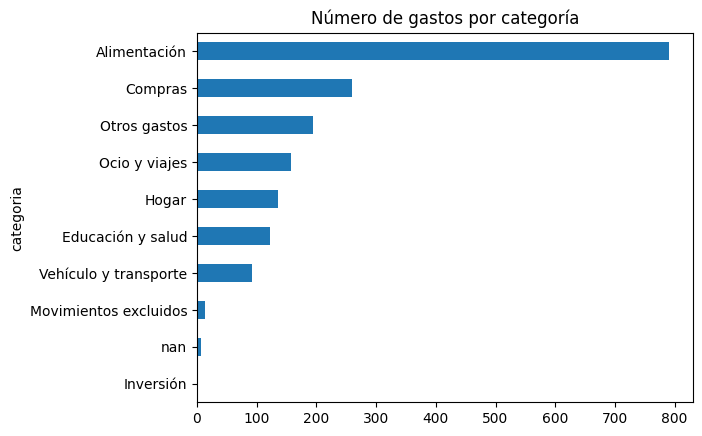

In [237]:
df_gastos[df_gastos.cluster==0].groupby(["categoria"])["importe"].count().sort_values().plot.barh(title="Número de gastos por categoría");

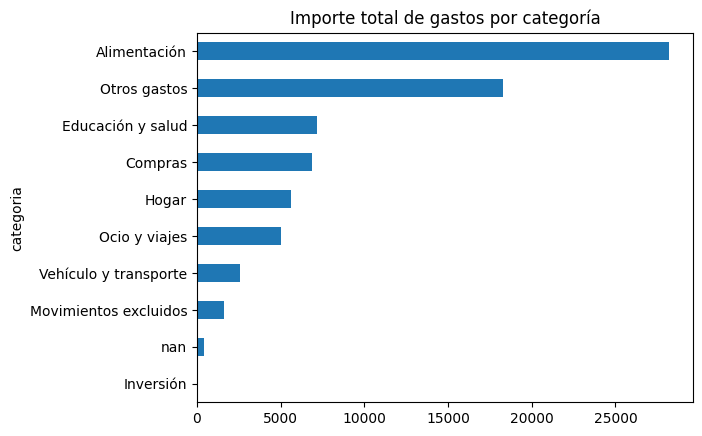

In [238]:
df_gastos[df_gastos.cluster==0].groupby(["categoria"])["importe"].sum().sort_values().plot.barh(title="Importe total de gastos por categoría");

#### Gastos del colegio : Segundo grupo más grande

In [239]:
df_gastos[df_gastos.cluster==1].importe.describe()

count     68.000000
mean     327.180441
std       22.105551
min      300.000000
25%      313.000000
50%      319.500000
75%      343.127500
max      377.530000
Name: importe, dtype: float64

In [240]:
df_gastos[df_gastos.cluster==1]

,fecha_valor,mes_valor,anio_valor,importe,categoria,cluster
9,2025-01-02,1,2025,352.79,Educación y salud,1
19,2025-01-02,1,2025,340.85,Educación y salud,1
67,2025-02-03,2,2025,319.50,Educación y salud,1
68,2025-02-03,2,2025,319.50,Educación y salud,1
130,2025-03-03,3,2025,319.50,Educación y salud,1
...,...,...,...,...,...,...
2015,2023-11-02,11,2023,366.41,Educación y salud,1
2049,2023-12-01,12,2023,325.34,Educación y salud,1
2050,2023-12-01,12,2023,313.86,Educación y salud,1
2136,2025-12-01,12,2025,354.76,Educación y salud,1


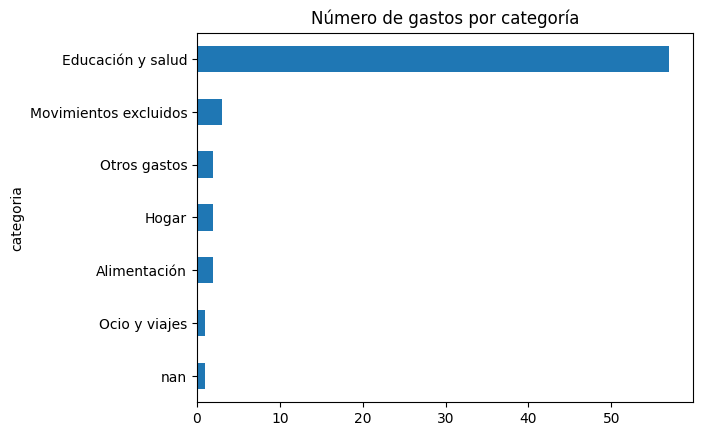

In [241]:
df_gastos[df_gastos.cluster==1].groupby(["categoria"])["importe"].count().sort_values().plot.barh(title="Número de gastos por categoría");

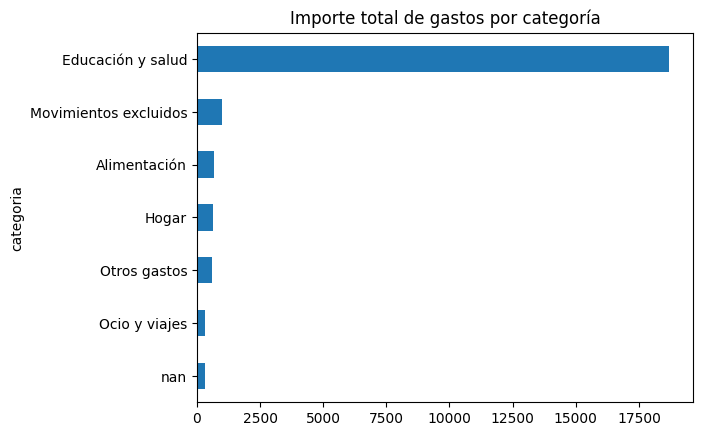

In [242]:
df_gastos[df_gastos.cluster==1].groupby(["categoria"])["importe"].sum().sort_values().plot.barh(title="Importe total de gastos por categoría");

#### Grupo de Otros gastos y Alimentación

In [243]:
df_gastos[df_gastos.cluster==2].importe.describe()

count     29.000000
mean     262.084483
std        4.548964
min      250.000000
25%      263.000000
50%      263.000000
75%      263.000000
max      270.000000
Name: importe, dtype: float64

In [244]:
df_gastos[df_gastos.cluster==2]

,fecha_valor,mes_valor,anio_valor,importe,categoria,cluster
104,2025-02-21,2,2025,257.88,Compras,2
121,2025-02-28,2,2025,263.00,Otros gastos,2
203,2025-04-05,4,2025,257.06,Alimentación,2
320,2025-05-27,5,2025,265.00,Otros gastos,2
321,2025-05-27,5,2025,250.00,Otros gastos,2
445,2025-07-27,7,2025,270.00,Otros gastos,2
676,2023-08-18,8,2023,269.90,Alimentación,2
747,2023-08-01,8,2023,270.00,Otros gastos,2
845,2023-06-28,6,2023,263.00,Otros gastos,2
922,2023-05-28,5,2023,263.00,Otros gastos,2


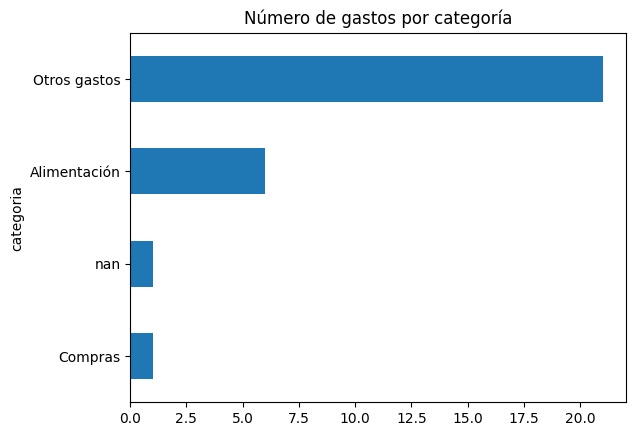

In [245]:
df_gastos[df_gastos.cluster==2].groupby(["categoria"])["importe"].count().sort_values().plot.barh(title="Número de gastos por categoría");

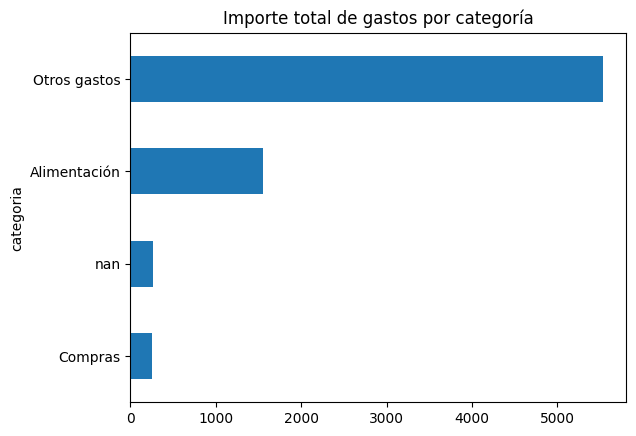

In [246]:
df_gastos[df_gastos.cluster==2].groupby(["categoria"])["importe"].sum().sort_values().plot.barh(title="Importe total de gastos por categoría");

#### Grupo XXX: Pendiente determinar


In [247]:
df_gastos[df_gastos.cluster==3].importe.describe()

count     11.000000
mean     397.446364
std        5.711112
min      385.000000
25%      394.185000
50%      398.400000
75%      400.555000
max      404.130000
Name: importe, dtype: float64

In [248]:
df_gastos[df_gastos.cluster==3]

,fecha_valor,mes_valor,anio_valor,importe,categoria,cluster
393,2025-06-30,6,2025,400.00,Otros gastos,3
570,2025-10-01,10,2025,404.13,Educación y salud,3
571,2025-10-01,10,2025,398.40,Educación y salud,3
589,2025-10-07,10,2025,400.00,Otros gastos,3
641,2025-11-03,11,2025,404.13,Educación y salud,3
642,2025-11-03,11,2025,398.40,Educación y salud,3
1099,2023-03-13,3,2023,401.11,Hogar,3
1141,2023-09-01,9,2023,385.00,Educación y salud,3
1726,2024-10-01,10,2024,392.37,Educación y salud,3
1799,2024-11-04,11,2024,392.37,Educación y salud,3


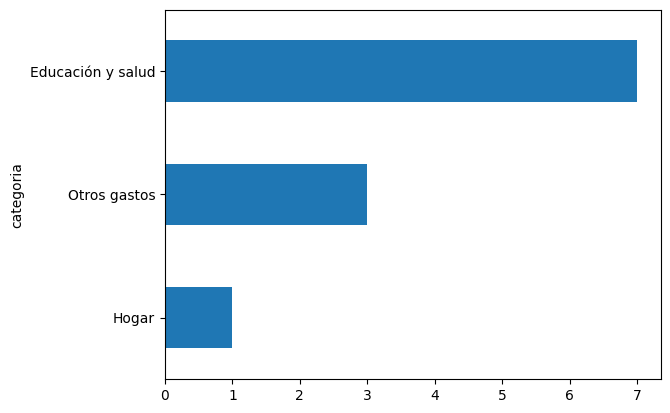

In [249]:
df_gastos[df_gastos.cluster==3].groupby(["categoria"])["importe"].count().sort_values().plot.barh();